In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
MRI = datasets.ImageFolder(root='E:\EPOCH 2.0\Dataset\Brain Tumor MRI images', transform=transform_train)
MRI_train_size = int(0.8 * len(MRI))
MRI_test_size = len(MRI) - MRI_train_size
MRI_train_dataset, MRI_test_dataset = random_split(MRI, [MRI_train_size, MRI_test_size])
MRI_test_dataset.dataset.transform = transform_test  # Apply test transform

MRI_train_loader = DataLoader(MRI_train_dataset, batch_size=32, shuffle=True)
MRI_test_loader = DataLoader(MRI_test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.5764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid 

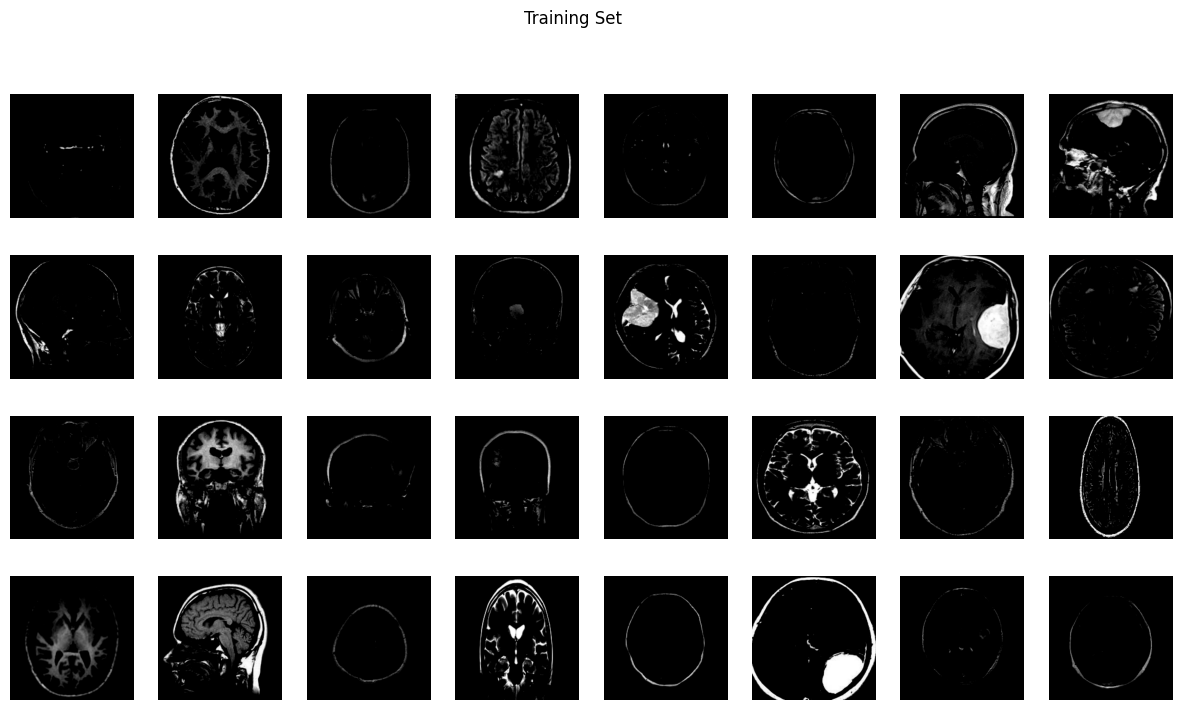

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid

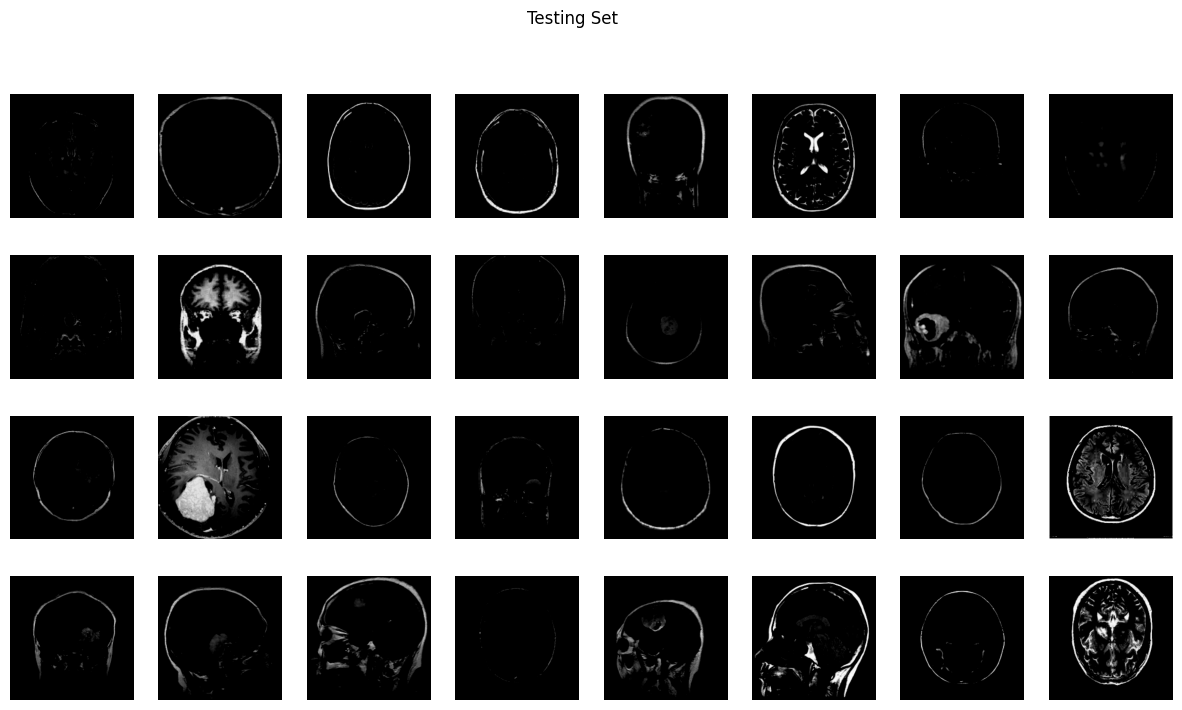

In [6]:
def show_batch(dataloader, title="Batch of MRI Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
    plt.show()

show_batch(MRI_train_loader, "Training Set")
show_batch(MRI_test_loader, "Testing Set")

In [7]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

In [8]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)  # Assuming binary classification (Healthy vs Tumor)
)
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

In [10]:
early_stop_patience = 7
best_acc = 0
patience_counter = 0
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(MRI_train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    model.eval()
    correct, total = 0, 0
    all_labels, all_predictions = [], []
    with torch.no_grad():
        for images, labels in MRI_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        val_acc = 100 * correct / total
        scheduler.step(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(MRI_train_loader):.4f}, Accuracy: {val_acc:.2f}%")
    
    # Early Stopping check
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_mri_model.pth')  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print("Early stopping triggered!")
        break

# Load the best model
model.load_state_dict(torch.load('best_mri_model.pth'))


100%|██████████| 125/125 [12:30<00:00,  6.00s/it]


Epoch [1/2], Loss: 0.3289, Accuracy: 93.80%


100%|██████████| 125/125 [11:25<00:00,  5.49s/it]


Epoch [2/2], Loss: 0.2224, Accuracy: 94.70%


<All keys matched successfully>

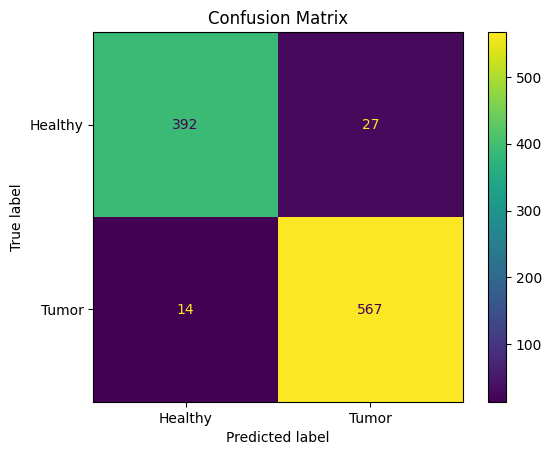

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid

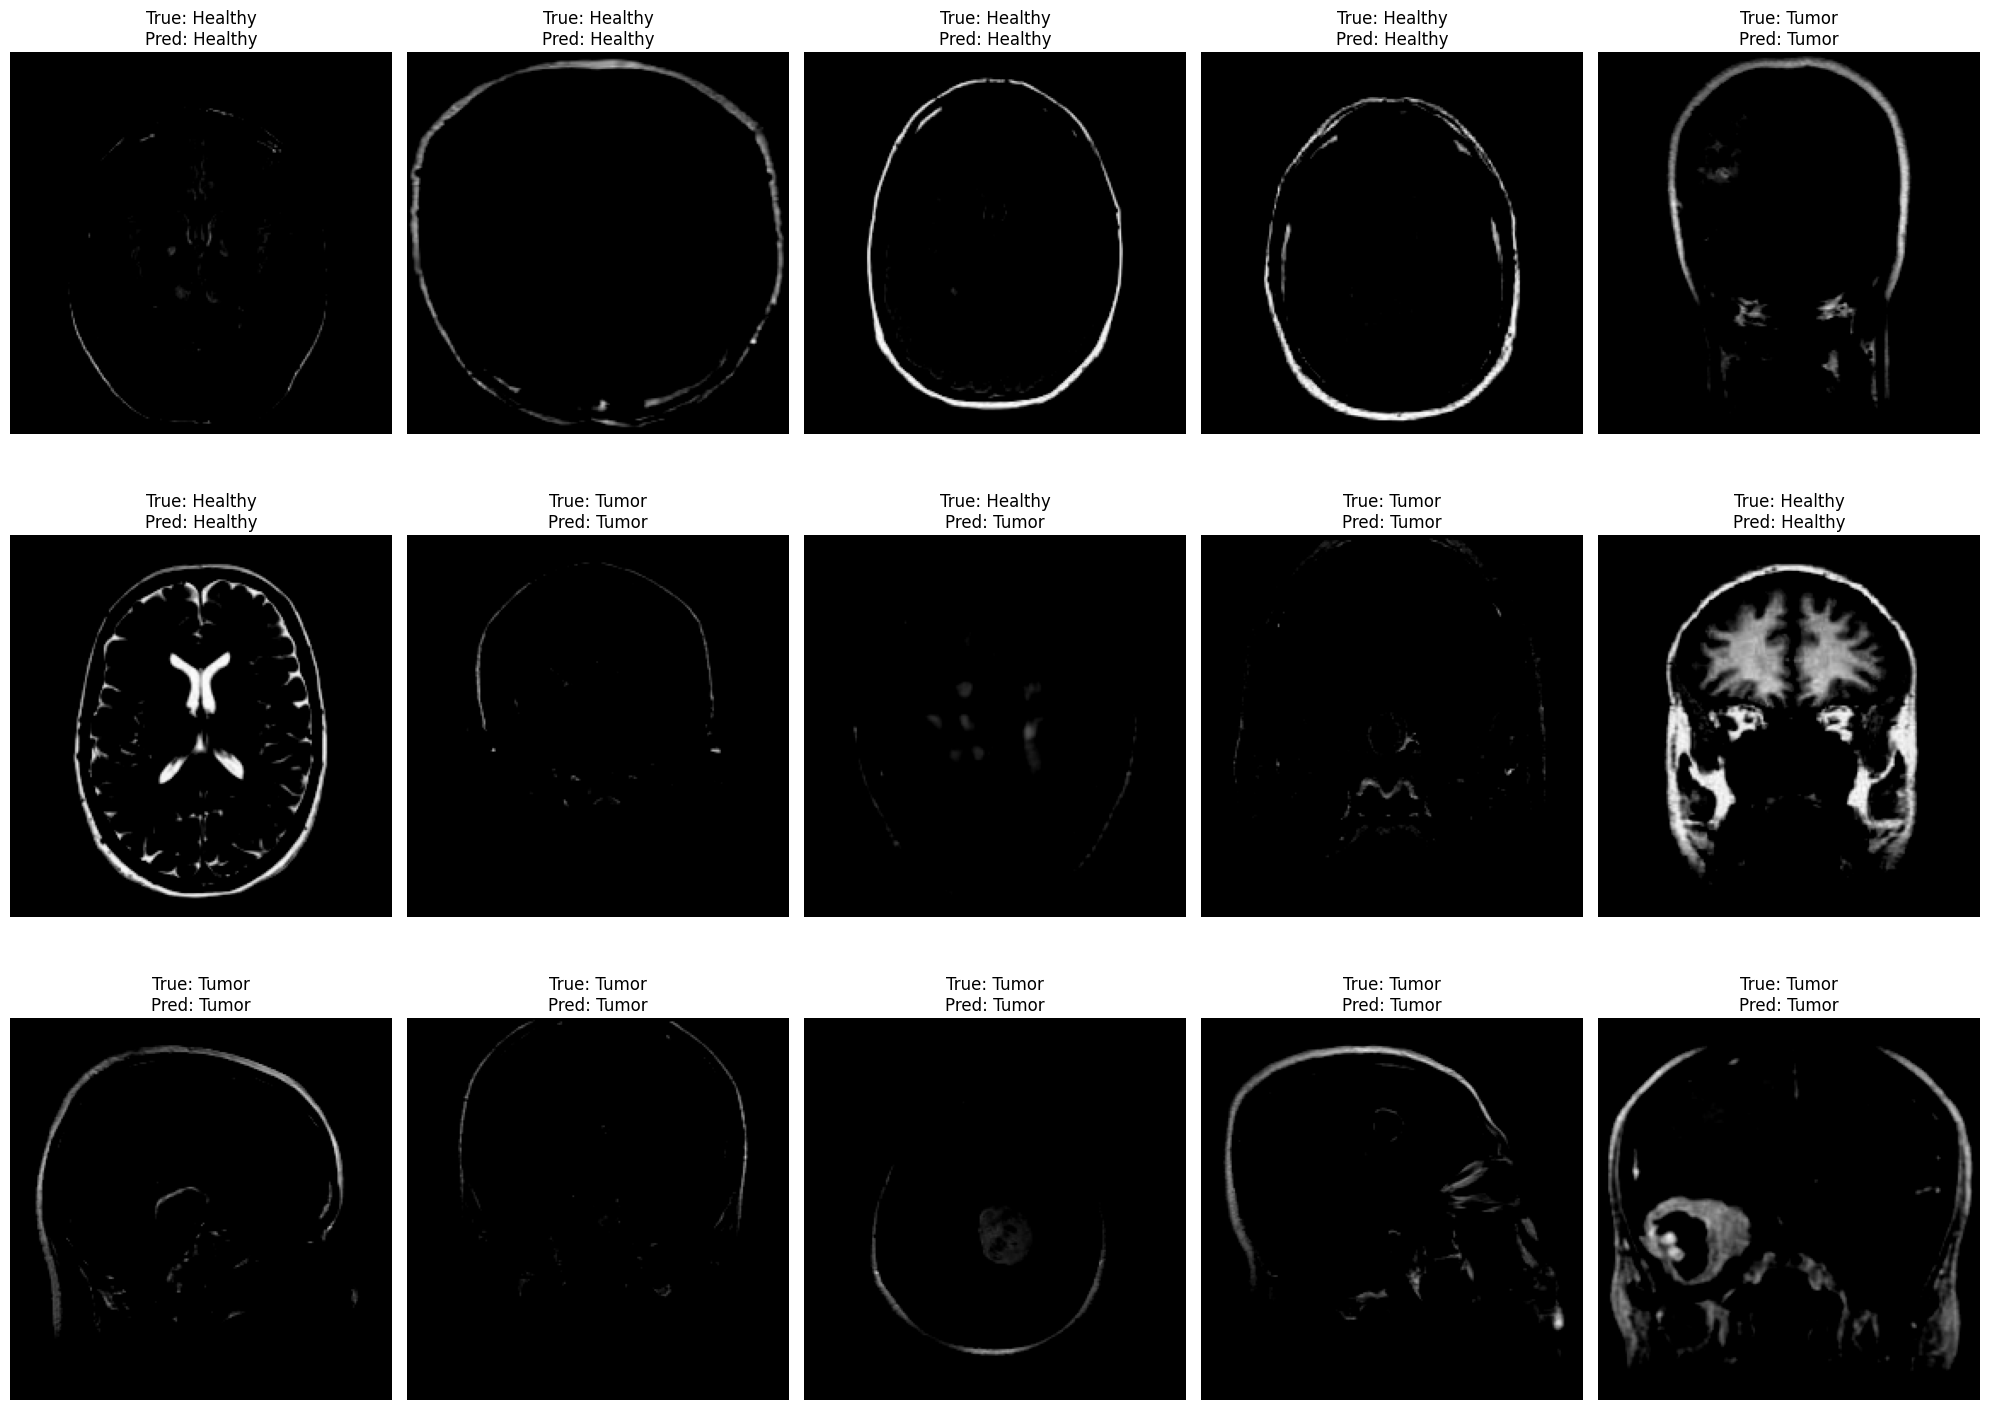

In [13]:
model.eval()
sample_images, sample_labels = next(iter(MRI_test_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
logits = model(sample_images)
_, preds = torch.max(logits, 1)

true_labels = [MRI.classes[label.item()] for label in sample_labels]
pred_labels = [MRI.classes[pred.item()] for pred in preds]

plt.figure(figsize=(20, 15))  # Adjust size for better visibility
rows, cols = 3,5

for idx in range(15):  
    plt.subplot(rows, cols, idx + 1)  
    img = sample_images[idx].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# CT SCAN 

In [11]:
#Importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [15]:
#Device agnostic code
if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu"
#Resizing images and turning them into tensors for matrix operations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#Creating Dataloaders for Computer Tomography
CT = datasets.ImageFolder(root=r'E:\EPOCH 2.0\Dataset\Brain Tumor CT scan Images', transform=transform)

CT_dataloader = DataLoader(CT, batch_size=32, shuffle=True)
CT_train_size = int(0.8 * len(CT))
CT_test_size = len(CT) - CT_train_size  

CT_train_dataset, CT_test_dataset = random_split(CT, [CT_train_size, CT_test_size])

CT_train_loader = DataLoader(CT_train_dataset, batch_size=32, shuffle=True)
CT_test_loader = DataLoader(CT_test_dataset, batch_size=32, shuffle=True)

print("CT Training set size:", len(CT_train_dataset))
print("CT Testing set size:", len(CT_test_dataset))

CT Training set size: 3694
CT Testing set size: 924


In [16]:
print("CT Classes:", CT.classes)

CT Classes: ['Healthy', 'Tumor']


In [17]:
#Functions for showing batches

def show_CT_batch(dataloader, title="Batch of CT Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting
            ax.imshow(img)
            ax.set_title(CT.classes[labels[i]])
            ax.axis('off')
    plt.show()

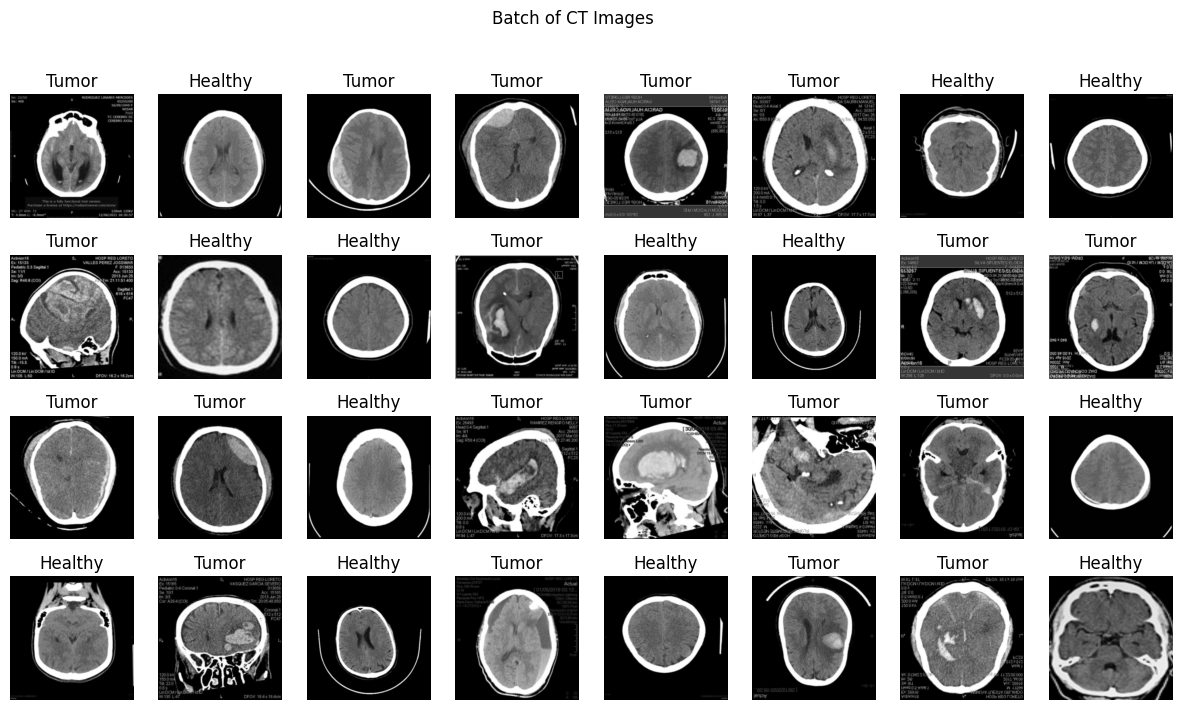

In [18]:
show_CT_batch(CT_train_loader)

In [19]:
#Computer Tomography CNN Model

class CTModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: 224x224x32
            nn.ReLU(),
            
            # Second convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Output: 224x224x64
            nn.ReLU(),
            
            # First max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64
            
            # Third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Output: 112x112x128
            nn.ReLU(),
            
            # Fourth convolutional layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # Output: 112x112x256
            nn.ReLU(),
            
            # Second max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x256
            
            # Fifth convolutional layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),  # Output: 56x56x512
            nn.ReLU(),
            
            # Sixth convolutional layer
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),  # Output: 56x56x1024
            nn.ReLU(),
            
            # Third max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 28x28x1024
            
            # Fourth max pooling layer 
            nn.MaxPool2d(kernel_size=4, stride=4),  # Output: 7x7x1024
            
            # Flatten layer
            nn.Flatten(),  # Output: 7x7x1024 = 50176
            
            # Fully connected layer
            nn.Linear(in_features=7 * 7 * 1024, out_features=256),  # Reduce dimensionality
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            
            # Final output layer
            nn.Linear(in_features=256, out_features=num_classes)  # Output: 2 (num_classes)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model
ct_model = CTModel(in_channels=3, num_classes=2)  # Assuming RGB input (3 channels)
print(ct_model)

CTModel(
  (layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_feat

In [20]:
#Criterion and Optimizer Selection
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(ct_model.parameters(),lr=0.001)
ct_model=ct_model.to(device)

In [23]:
#Train and Test Loop for PyTorch

from tqdm import tqdm

num_epochs = 2

ct_all_labels = []
ct_all_predictions = []

for epoch in range(num_epochs):
    ct_model.train()
    running_loss = 0.0
    for images, labels in tqdm(CT_train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = ct_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    ct_model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in tqdm(CT_test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = ct_model(images)
            _, predicted = torch.max(outputs, 1)

            ct_all_labels.extend(labels.cpu().numpy())
            ct_all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(CT_train_loader):.4f},Accuracy of the model on the validation set: {100 * correct / total:.2f}")

100%|██████████| 29/29 [02:16<00:00,  4.72s/it]


Epoch [1/2], Loss: 0.4025,Accuracy of the model on the validation set: 92.42


100%|██████████| 29/29 [02:10<00:00,  4.50s/it]

Epoch [2/2], Loss: 0.1803,Accuracy of the model on the validation set: 93.18


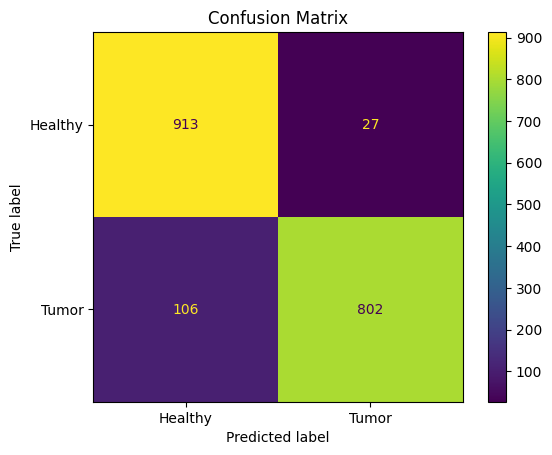

In [24]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ct_all_labels, ct_all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
torch.save(ct_model, 'ct_model.pth')  # Save the model
ct_saved = torch.load('ct_model.pth',weights_only=False)  # Load the model
ct_saved = ct_saved.to(device)

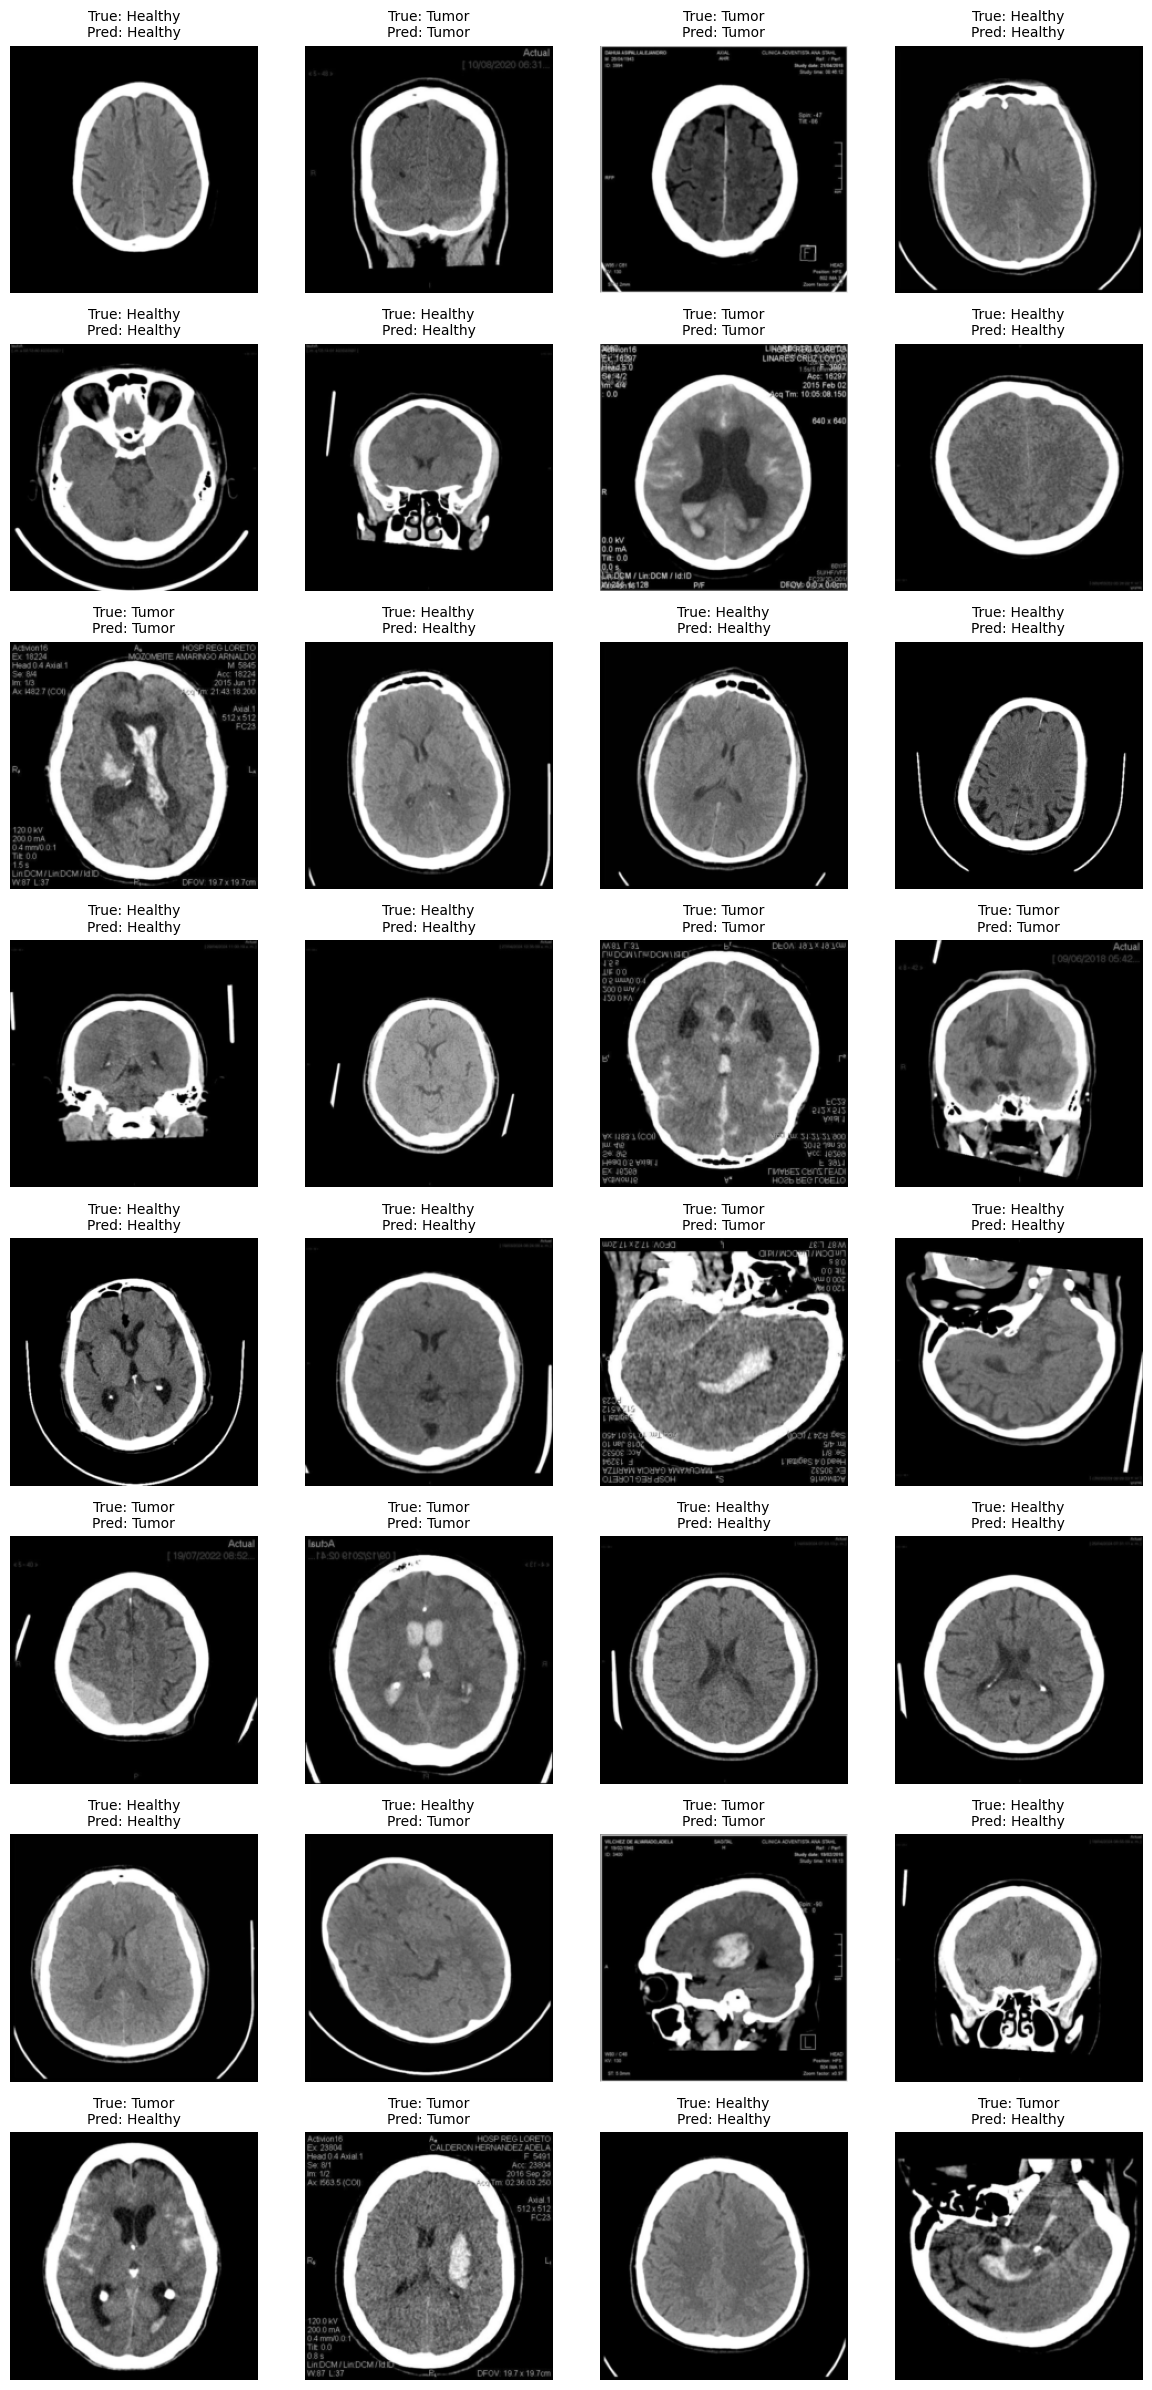

In [28]:
#Predicting some labels

ct_images, ct_labels = next(iter(CT_test_loader))

ct_images, ct_labels = ct_images.to(device), ct_labels.to(device)

ct_saved.eval()

logits = ct_saved(ct_images) 
_, predicted_indices = torch.max(logits, 1) 

true_labels = [CT.classes[label.item()] for label in ct_labels]
predicted_labels = [CT.classes[pred.item()] for pred in predicted_indices]

batch_size = len(ct_images)
cols = 4  
rows = (batch_size + cols - 1) // cols

plt.figure(figsize=(12, rows * 3))

for idx in range(batch_size):
    plt.subplot(rows, cols, idx + 1)
    img = ct_images[idx].cpu().permute(1, 2, 0).numpy()
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()